Compiling model...
Building feed-forward neural network...
'build' took 0.035837 s



/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+44=44. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecate

'compile' took 0.814533 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.74e+01, 7.62e+01, 1.39e-01, 2.27e+02]    [2.57e+01, 6.35e+01, 1.39e-01, 2.27e+02]    [9.52e-01]    
1000      [1.94e-01, 1.52e+00, 6.19e-03, 2.66e-02]    [1.59e-01, 9.29e-01, 6.19e-03, 2.66e-02]    [7.30e-01]    
2000      [1.35e-03, 8.15e-02, 2.62e-04, 6.98e-04]    [1.39e-03, 7.94e-02, 2.62e-04, 6.98e-04]    [7.28e-01]    
3000      [3.64e-04, 4.83e-02, 8.37e-05, 3.86e-04]    [3.73e-04, 4.84e-02, 8.37e-05, 3.86e-04]    [7.27e-01]    
4000      [1.48e-01, 5.71e-02, 3.17e-03, 6.86e-04]    [1.13e-01, 6.18e-02, 3.17e-03, 6.86e-04]    [7.29e-01]    
5000      [9.31e-05, 2.59e-02, 2.78e-05, 1.86e-04]    [6.83e-05, 2.69e-02, 2.78e-05, 1.86e-04]    [7.29e-01]    

Best model at step 5000:
  train loss: 2.62e-02
  test loss: 2.72e-02
  test metric: [7.29e-01]

'train' took 60.390224 s

Saving loss h

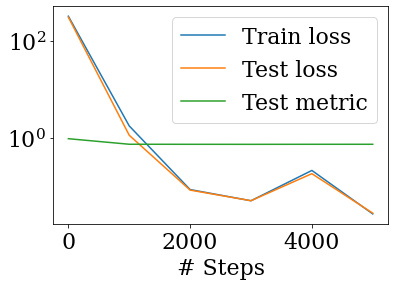

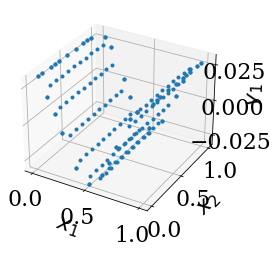

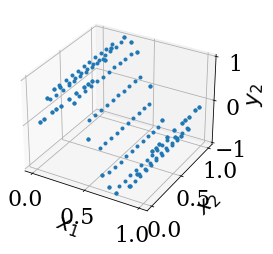

In [4]:
import deepxde as dde
import numpy as np

# General parameters
n = 1
precision_train = 10
precision_test = 10
weights = 10
epochs = 5000  # tested with 50.000 epochs.
parameters = [1e-3, 3, 130, "sin"]  # learning rate, depth, width, activation function

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters


def pde(x, y):
    yRe, yIm = y[:, 0:1], y[:, 1:2]
    dyRe_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    dyRe_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dyIm_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dyIm_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    # Projection to the real and imaginary axes
    return [
        -dyRe_xx - dyRe_yy - k0**2 * yRe,
        -dyIm_xx - dyIm_yy - k0**2 * yIm,
    ]


def func(x):
    real = np.cos(k0 * x[:, 0:1])
    imag = np.sin(k0 * x[:, 0:1])
    sol = np.exp(1j * k0 * x[:, 0:1])
    return np.hstack((np.real(sol), np.imag(sol)))
    #return np.hstack((real, imag))


def boundary(_, on_boundary):
    return on_boundary



geom = dde.geometry.Rectangle([0, 0], [1, 1])
k0 = 2 * np.pi * n
wave_len = 1 / n

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

def funcRe(x):
    normal = geom.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.real(g)

def funcIm(x):
    normal = geom.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.imag(g)

bcRe = dde.icbc.NeumannBC(geom, funcRe, boundary, component=0)
bcIm = dde.icbc.NeumannBC(geom, funcIm, boundary, component=1)

bcs = [bcRe, bcIm]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx_train**2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test**2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)

model = dde.Model(data, net)
loss_weights = [1, 1, weights, weights]
model.compile(
    "adam", lr=learning_rate, metrics=["l2 relative error"], loss_weights=loss_weights
)

losshistory, train_state = model.train(epochs=epochs)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Relative error =  0.7196679080662778


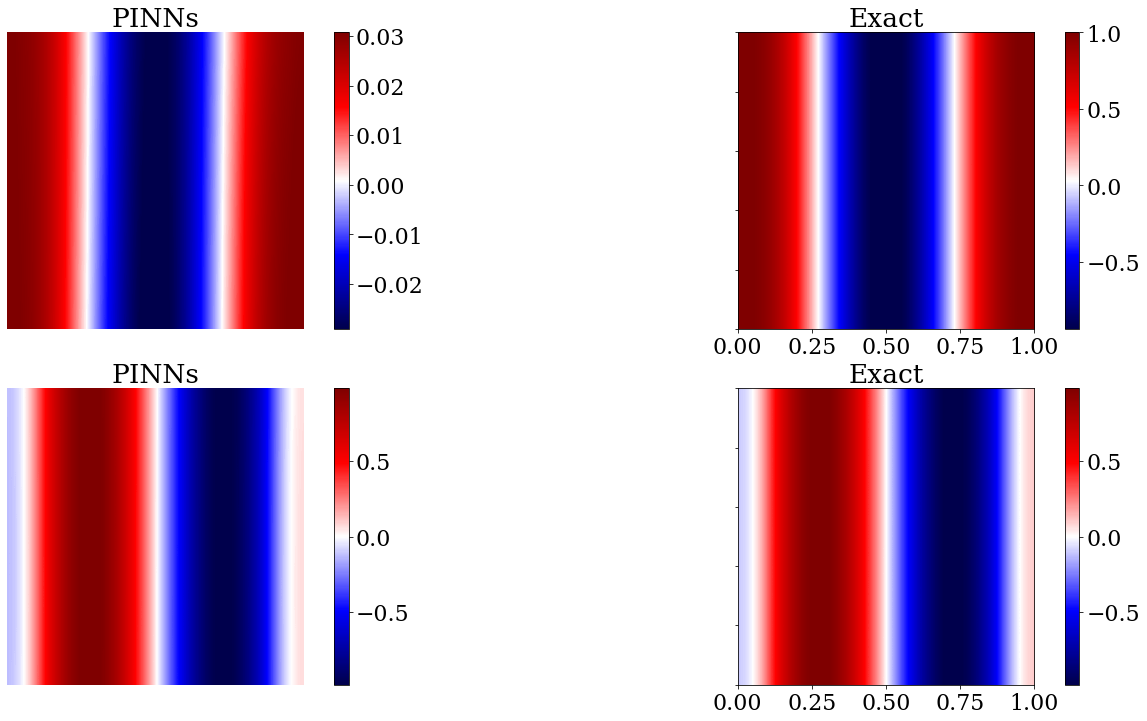

In [6]:
import matplotlib.pyplot as plt
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(1/wave_len * 10))
Ny = Nx


# Grid points
xmin, xmax, ymin, ymax = [0, 1, 0, 1]

plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

#in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
#in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
#points[0, in_circ] = -radius - wave_len / 10
#points[1, in_circ] = radius + wave_len / 10
#points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations

u = model.predict(points[:2, :].T)
u = u[:, 0] + 1j* u[:, 1]
u = u.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run

u_exact = func(points.T)
u_exact = u_exact[:, 0] + 1j* u_exact[:, 1]
u_exact = u_exact.reshape((Nx, Ny))

diff = u_exact-u
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.real(u)).T,
           extent=[0,1,0,1],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='Re PINN')

ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.real(u_exact)).T,
           extent=[0,1,0,1],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Re Exact')


#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)


pcm = ax3.imshow(np.fliplr(np.imag(u)).T,
           extent=[0,1,0,1],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='Im PINN')

ax3.axis('off')


pcm = ax4.imshow(np.fliplr(np.imag(u_exact)).T,
           extent=[0,1,0,1],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='Im Exact')

ax3.axis('off')

ax3.set_title('PINNs')
ax4.set_title('Exact')


fig.colorbar(pcm, ax = ax3)
fig.colorbar(pcm, ax = ax4)
